# SETUP

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
#imports
import os 
import pickle
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

#tensorflow
import tensorflow as tf
from keras.layers import Dense, LSTM, Bidirectional, RNN
from keras.layers.embeddings import Embedding
from keras.models import Sequential

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
DATA_PATH = '/content/drive/My Drive/Research/Deeplearning-in-IoT-systems/PP_Data/'

In [4]:
!nvidia-smi

Thu Sep 17 10:37:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# JS to keep Colab running
`
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
`



# LOAD DATA

In [5]:
def getData(datasetName):
    X = np.load(f"{DATA_PATH}{datasetName}_X.npy", allow_pickle=True)
    Y = np.load(f"{DATA_PATH}{datasetName}_Y.npy", allow_pickle=True)
    enc_dec = np.load(f"{DATA_PATH}/{datasetName}_ENCDEC.npy", allow_pickle=True)
    return X, Y, enc_dec

In [6]:
X, Y, (idx2act, idx2obs, act2idx, obs2idx) = getData('cairo')

# EDA

In [7]:
i = [1, 3, 4 ,5 ]
print('Example of input')
print('-'*40)
print()
for idx in i:
  print(f"sequence of sensor activations: {X[idx]}")
  print(f"activity: {Y[idx]}")
  print()

Example of input
----------------------------------------

sequence of sensor activations: [ 0  0  0 ...  9 16  8]
activity: 5

sequence of sensor activations: [ 0  0  0 ... 46 47 46]
activity: 6

sequence of sensor activations: [ 0  0  0 ... 43 42 68]
activity: 2

sequence of sensor activations: [ 0  0  0 ... 18 27 26]
activity: 6



[[Text(0, 0, 'Eat'),
  Text(0, 0, 'Leave_Home'),
  Text(0, 0, 'Other'),
  Text(0, 0, 'Sleep'),
  Text(0, 0, 'Take_medicine'),
  Text(0, 0, 'Use Toiltet'),
  Text(0, 0, 'Wake'),
  Text(0, 0, 'Work')],
 Text(0.5, 1.0, 'Activity distribution of cairo dataset')]

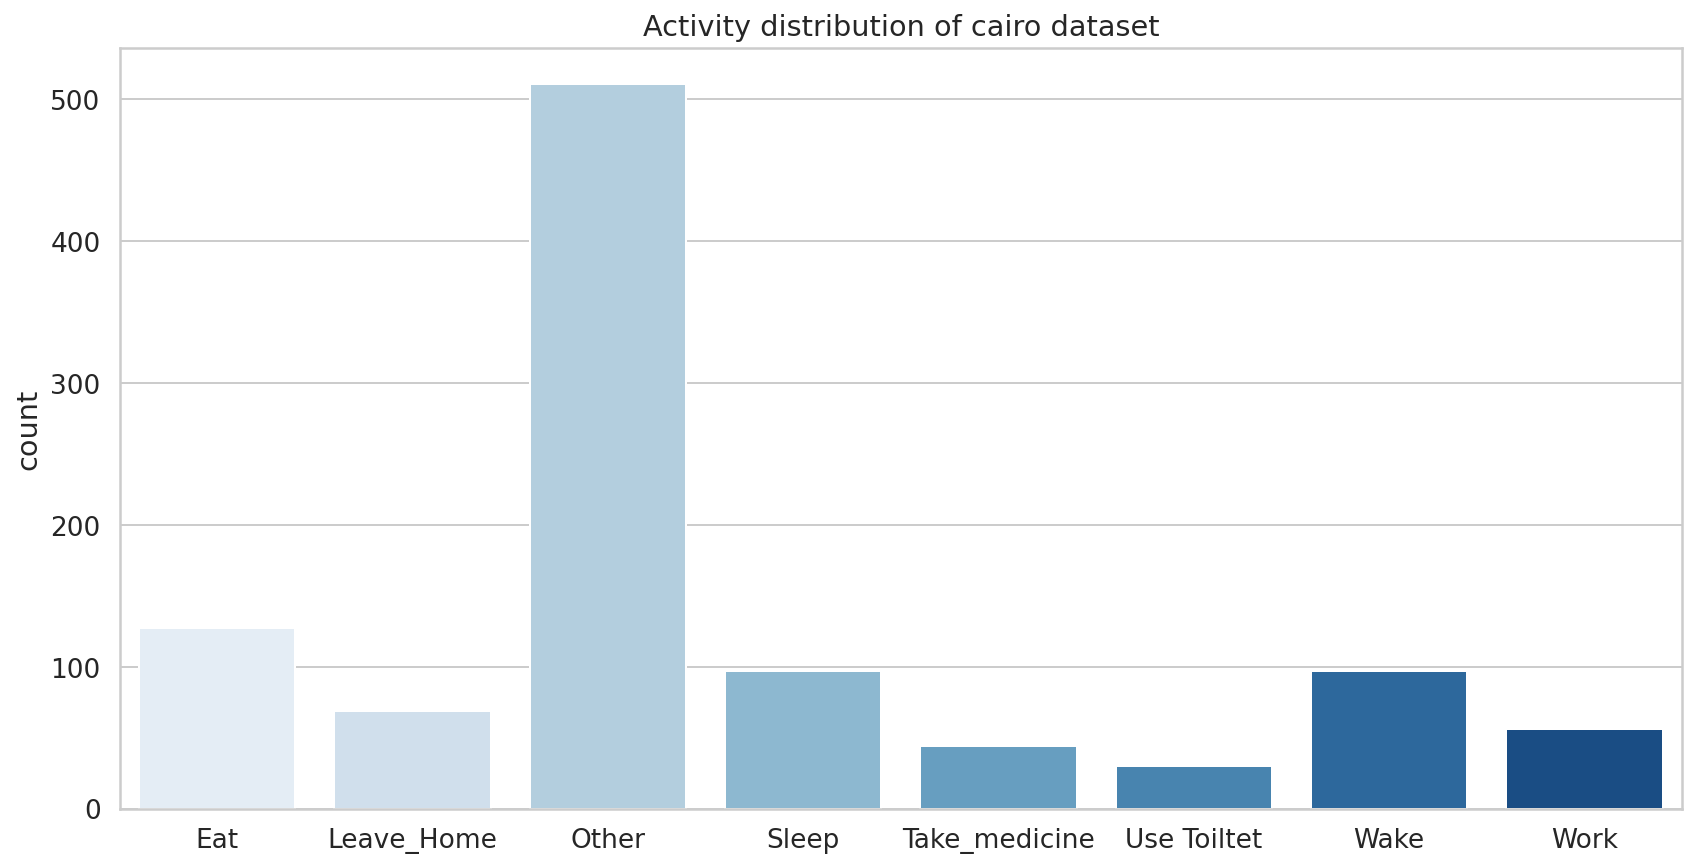

In [8]:
fig, ax = plt.subplots(figsize=(14,7))
sns.countplot(Y, ax=ax, palette=sns.color_palette('Blues', 8))
ax.set(xticklabels=idx2act, title = "Activity distribution of cairo dataset")

# TEST DATA SPLIT

In [9]:
split_point = int(0.1 * len(X))
X_test = X[:split_point]
Y_test = Y[:split_point]
X_train = X[split_point:]
Y_train = Y[split_point:]

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Train set size: 928
Test set size: 103


# MODEL ARCH

In [10]:
# LSTM 
def get_LSTM(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER):
  model = Sequential(name='LSTM')
  model.add(Embedding(INPUT_DIM, N_HIDDEN, input_length=MAX_LENGTH, mask_zero=True))
  model.add(LSTM(N_HIDDEN))
  model.add(Dense(NO_ACTIVITIES, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
  return model

In [11]:
INPUT_DIM = len(X)
NO_ACTIVITIES = len(np.unique(Y))
MAX_LENGTH = 2000
N_HIDDEN = 64
OPTIMIZER = 'adam'
EPOCHS = 50

In [12]:
model = get_LSTM(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER)

In [13]:
model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 64)          65984     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
Total params: 99,528
Trainable params: 99,528
Non-trainable params: 0
_________________________________________________________________


In [14]:
!pwd

/content


In [15]:
# setup-settings:
config = {
    "name" : model.name,
    "epochs" : EPOCHS,
    "n_hidden" : N_HIDDEN,
    "input_dim" : INPUT_DIM,
    "opt": OPTIMIZER,
    "summary": model.get_config()
}
with open('config.json', 'w') as fp:
    json.dump(config, fp)

# Training

In [16]:
X_np = np.array(X_train, dtype=np.int32)
Y_np = np.array(Y_train, dtype=np.int32)

In [17]:
X_tensor = tf.convert_to_tensor(X_np, dtype=tf.float32)
Y_tensor = tf.convert_to_tensor(Y_np, dtype=tf.float32)

In [18]:
history = model.fit(X_tensor, Y_tensor, validation_split=0.2, batch_size=64, verbose=1, epochs=EPOCHS)

Epoch 1/50
12/12 [==============================] - 44s 4s/step - loss: 2.0158 - accuracy: 0.4650 - val_loss: 1.8762 - val_accuracy: 0.4946
Epoch 2/50
12/12 [==============================] - 43s 4s/step - loss: 1.6221 - accuracy: 0.4946 - val_loss: 1.6216 - val_accuracy: 0.4946
Epoch 3/50
12/12 [==============================] - 46s 4s/step - loss: 1.4634 - accuracy: 0.5081 - val_loss: 1.4296 - val_accuracy: 0.5376
Epoch 4/50
12/12 [==============================] - 45s 4s/step - loss: 1.3071 - accuracy: 0.5539 - val_loss: 1.3136 - val_accuracy: 0.5699
Epoch 5/50
12/12 [==============================] - 45s 4s/step - loss: 1.1657 - accuracy: 0.6415 - val_loss: 1.2326 - val_accuracy: 0.6505
Epoch 6/50
12/12 [==============================] - 44s 4s/step - loss: 1.1157 - accuracy: 0.6509 - val_loss: 1.0775 - val_accuracy: 0.6559
Epoch 7/50
12/12 [==============================] - 44s 4s/step - loss: 0.9893 - accuracy: 0.6725 - val_loss: 1.0452 - val_accuracy: 0.6613
Epoch 8/50
12/12 [==

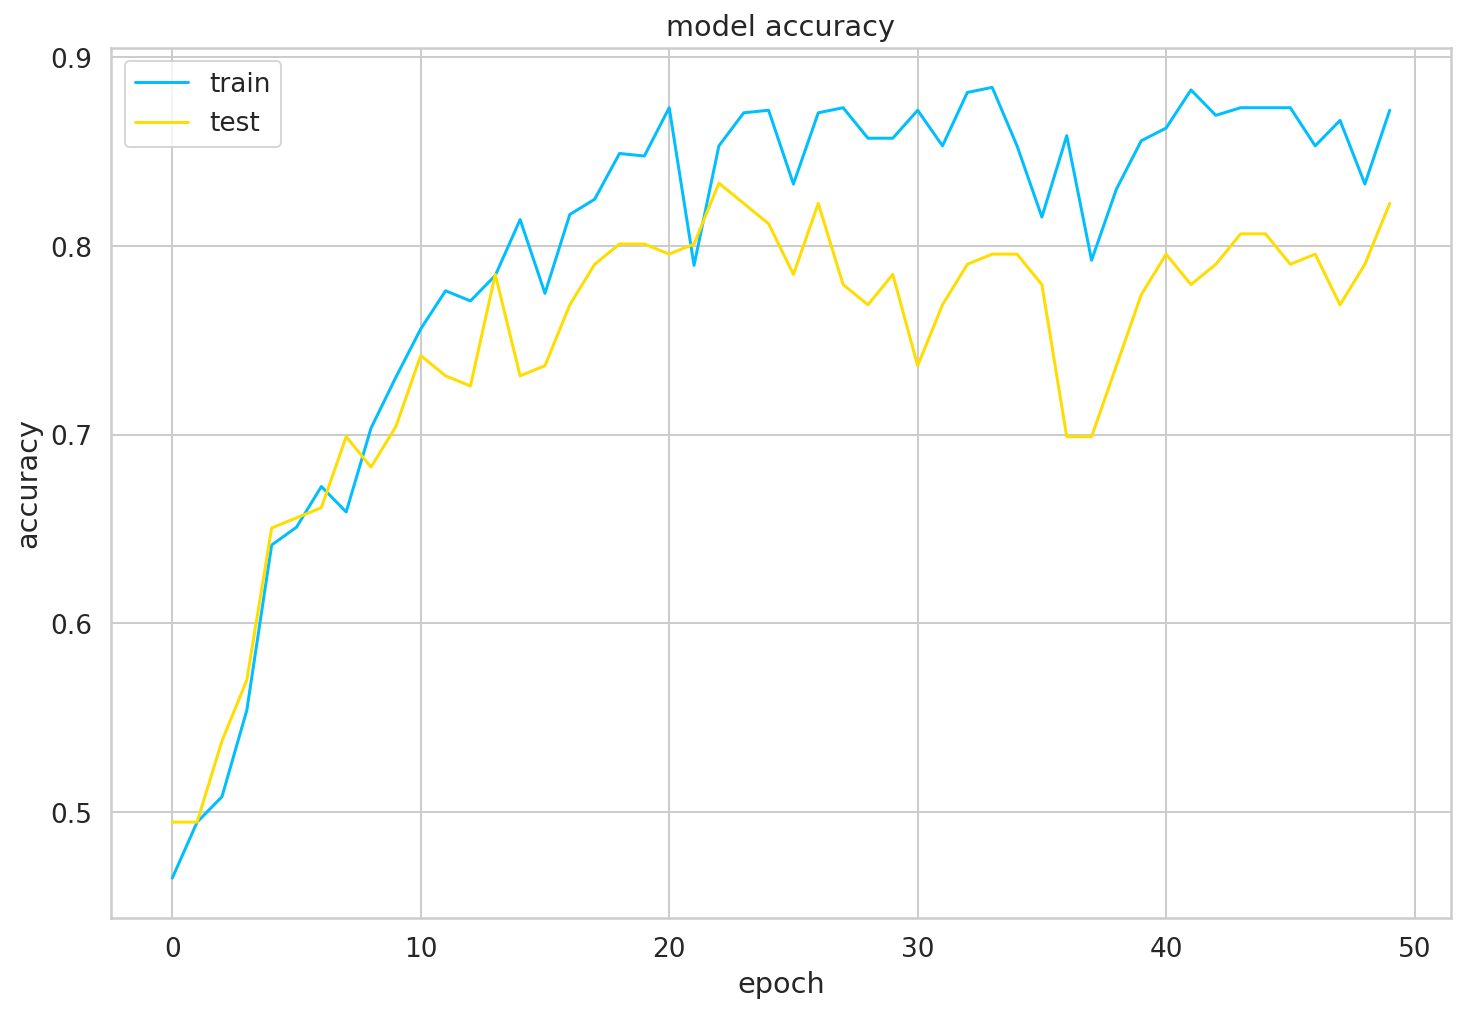

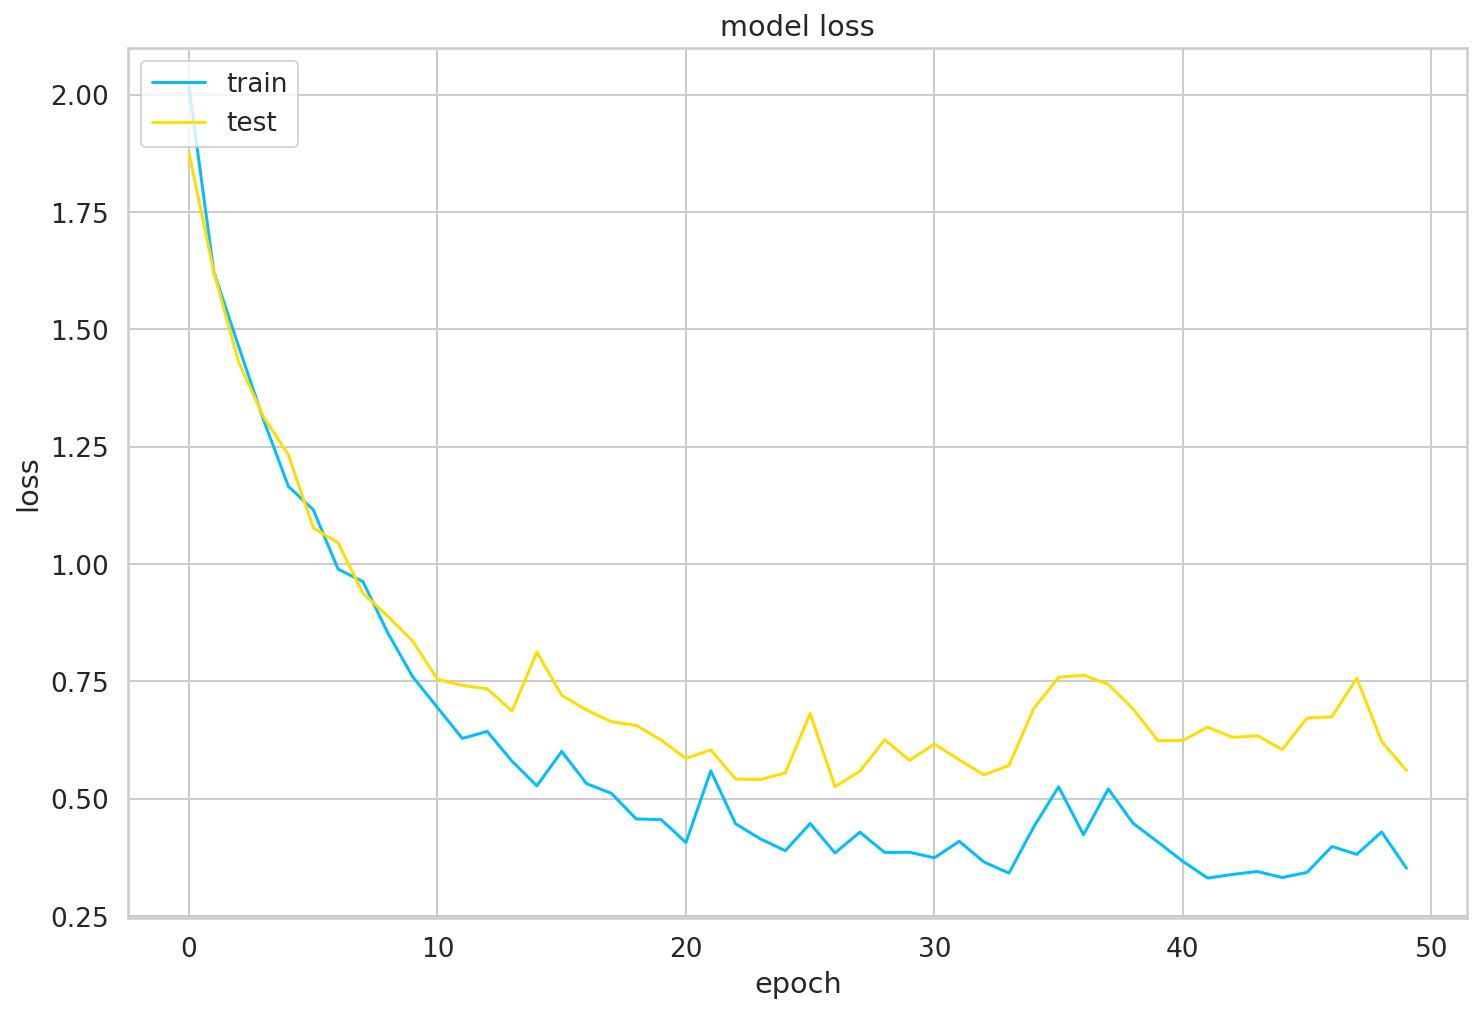

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
def get_class_acc(X_test, Y_test, model, idx2act):
  preds = np.array(np.argmax(model.predict(X_test), axis=-1), dtype=np.int32)
  targets = np.array(Y_test, dtype=np.int32)
  correct = {}
  total = {}
  for i in range(len(idx2act)):
    correct[i] = 1 
    total[i] = 1
  for i, pred in enumerate(preds):
    if pred == targets[i]:
      correct[pred] +=1
    total[pred]+=1
  
  for i, act in enumerate(idx2act):
    print(f"{act} : {correct[i]}/{total[i]}  [{round(correct[i]/total[i]*100,2)} %]")

In [24]:
get_class_acc(X_tensor, Y_tensor, model, idx2act)

Eat : 100/117  [85.47 %]
Leave_Home : 63/66  [95.45 %]
Other : 415/445  [93.26 %]
Sleep : 76/116  [65.52 %]
Take_medicine : 37/38  [97.37 %]
Use Toiltet : 1/1  [100.0 %]
Wake : 73/100  [73.0 %]
Work : 49/53  [92.45 %]


# Evaluation

In [25]:
X_np_test = np.array(X_test, dtype=np.int32)
Y_np_test = np.array(Y_test, dtype=np.int32)
X_tensor_test = tf.convert_to_tensor(X_np_test, dtype=tf.float32)
Y_tensor_test = tf.convert_to_tensor(Y_np_test, dtype=tf.float32)

In [26]:
scores = model.evaluate(X_tensor_test, Y_tensor_test, batch_size=64, verbose=1)
print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))

2/2 [==============================] - 0s 132ms/step - loss: 0.8751 - accuracy: 0.7184
accuracy: 71.84%


In [27]:
get_class_acc(X_tensor_test, Y_tensor_test, model, idx2act)

Eat : 4/10  [40.0 %]
Leave_Home : 7/7  [100.0 %]
Other : 45/58  [77.59 %]
Sleep : 10/16  [62.5 %]
Take_medicine : 5/6  [83.33 %]
Use Toiltet : 1/1  [100.0 %]
Wake : 8/11  [72.73 %]
Work : 2/2  [100.0 %]
